In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

import os

import torch.nn as nn
import torch

from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Creating data

In [2]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            image = os.path.join(label, j)
            dd["images"] += [image]
            dd["labels"] += [i]
    return pd.DataFrame(dd)

In [3]:
df = create_df("/kaggle/input/fracture-classification-dataset/FracAtlas/images")

In [4]:
label_index = {"Fractured": 1, "Non_fractured": 0}
index_label = dict()
for i, j in label_index.items():
    index_label[j] = i

In [5]:
df["labels"] = df["labels"].map(label_index)

# Training parameters

In [6]:
EPOCHS = 20
IMG_SIZE = 224
LR = 0.3
STEP = 7
BATCH = 32
GAMMA = 0.75
OUT_CLASSES = 2

# Dataset pipeline and transformation pipeline

In [7]:
class Pipeline(Dataset):
    def __init__(self, data, transform, tr1d):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform
        self.tr1d = tr1d
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = Image.open(img)
        img = np.array(img)
        if img.ndim == 3:
            img = self.transform(img)
        else:
            img = self.tr1d(img)
            b = torch.zeros(3, 224, 224)
            img = torch.add(img, b)
        
        return img, label

In [8]:
transform = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                   transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

transform_1d = transforms.Compose([transforms.ToPILImage(mode='L'),
                                   transforms.ToTensor(),
                                   transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                   transforms.Normalize(mean=[0.5], 
                                                        std=[0.5])])

# Randomly Cropping dataset to deal with class imbalances

In [9]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

rus = RandomUnderSampler()
x, y = rus.fit_resample(x, y)

data = np.hstack((x, y.reshape(-1, 1)))

In [10]:
train, validate = train_test_split(data, random_state=42, test_size=0.2)
val, test = train_test_split(validate, random_state=42, test_size=0.5)

In [11]:
train_ds = Pipeline(train, transform, transform_1d)
val_ds = Pipeline(val, transform, transform_1d)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# ResNet defined

In [12]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s] 


# Softmax added

In [13]:
class FractureClassifier(nn.Module):
    def __init__(self, model):
        super(FractureClassifier, self).__init__()
        self.model = model
        
    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

# Training hardware

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Training tools

In [15]:
model = FractureClassifier(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training

In [16]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    diff = 0
    acc = 0
    total = 0
    
    for data, label in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()
        out = model(data)
        loss = criterion(out, label)
        diff += loss.item()
        acc += (out.argmax(1) == label).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    diff = 0
    acc = 0
    total = 0
    with torch.no_grad():
        for data, label in val_dl:
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()
            out = model(data)
            loss = criterion(out, label)
            diff += loss.item()
            acc += (out.argmax(1) == label).sum().item()
            total += out.size(0)
        
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
    
    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                   train_acc[-1], val_loss[-1],
                                                                   val_acc[-1]))
    scheduler.step()

Epoch 1 train loss 0.019008282510321765 acc 0.6817785527462947 val loss 0.02042820820441613 acc 0.6993006993006993
Epoch 2 train loss 0.016311139647817236 acc 0.7811682650392328 val loss 0.016728072316496524 acc 0.8251748251748252
Epoch 3 train loss 0.015117973608875025 acc 0.8256320836965998 val loss 0.02014065914220743 acc 0.7062937062937062
Epoch 4 train loss 0.014423366723729927 acc 0.8544027898866609 val loss 0.01814055734581047 acc 0.7832167832167832
Epoch 5 train loss 0.013434258303438567 acc 0.8866608544027899 val loss 0.01764559037201888 acc 0.7972027972027972
Epoch 6 train loss 0.013819265308438328 acc 0.8648648648648649 val loss 0.023910830070922425 acc 0.6013986013986014
Epoch 7 train loss 0.013728936210131791 acc 0.8709677419354839 val loss 0.01879294477142654 acc 0.7692307692307693
Epoch 8 train loss 0.012629327092258018 acc 0.9084568439407149 val loss 0.017494446122562967 acc 0.7902097902097902
Epoch 9 train loss 0.011616219384003017 acc 0.9450741063644289 val loss 0.015

# Training performance log

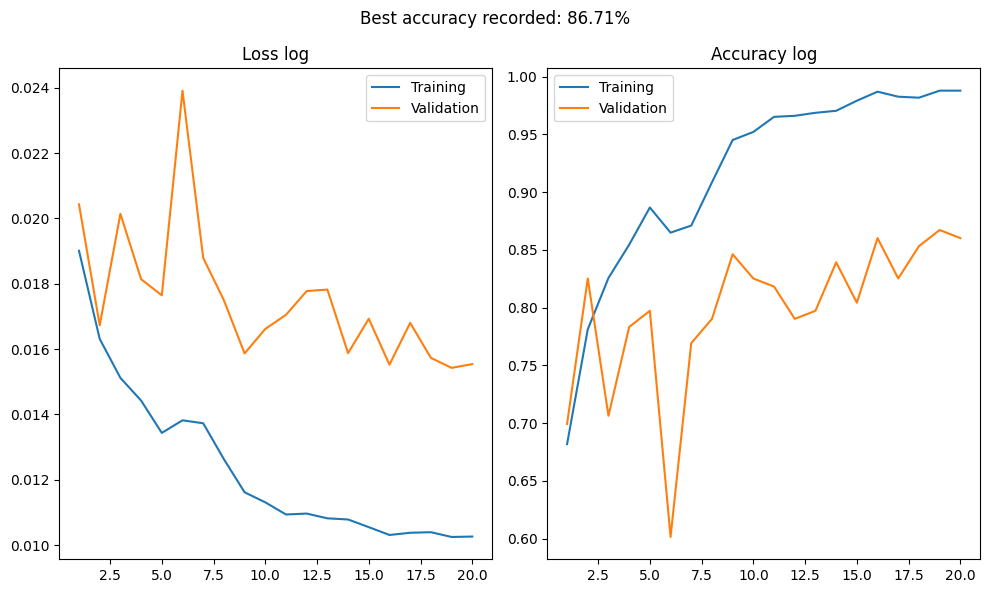

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
epochs = list(range(1, EPOCHS+1))


axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.suptitle("Best accuracy recorded: {}%".format(round(best_acc*100, 2)))
plt.tight_layout()
plt.show()

# Testing

In [18]:
def predict(x):
    img = Image.open(x)
    img = np.array(img)
    if img.ndim == 3:
        img = transform(np.array(img))
        img = img.view([1, 3, IMG_SIZE, IMG_SIZE])
    else:
        img = transform_1d(np.array(img))
        img = img.view([1, 1, IMG_SIZE, IMG_SIZE])
        b = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
        img = torch.add(img, b)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)
    label = out.argmax(1).item()
    return label, out[0][label].item()

In [19]:
truth = []
probs = []
pred = []

for i in range(test.shape[0]):
    label, prob = predict(test[i, 0])
    truth += [label]
    probs += [prob]
    pred += [test[i, -1]]

              precision    recall  f1-score   support

           0       0.75      0.78      0.77        69
           1       0.79      0.76      0.78        75

    accuracy                           0.77       144
   macro avg       0.77      0.77      0.77       144
weighted avg       0.77      0.77      0.77       144



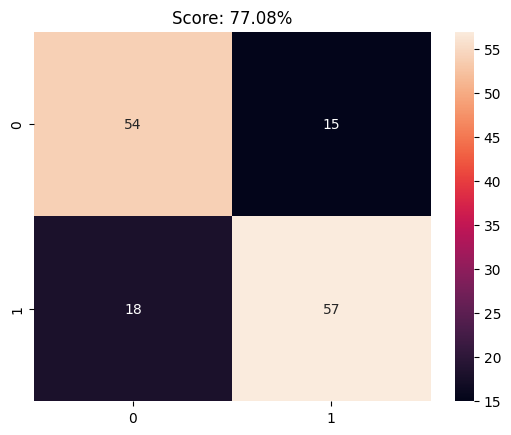

In [20]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
print(report)
sns.heatmap(cm, annot=True)
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

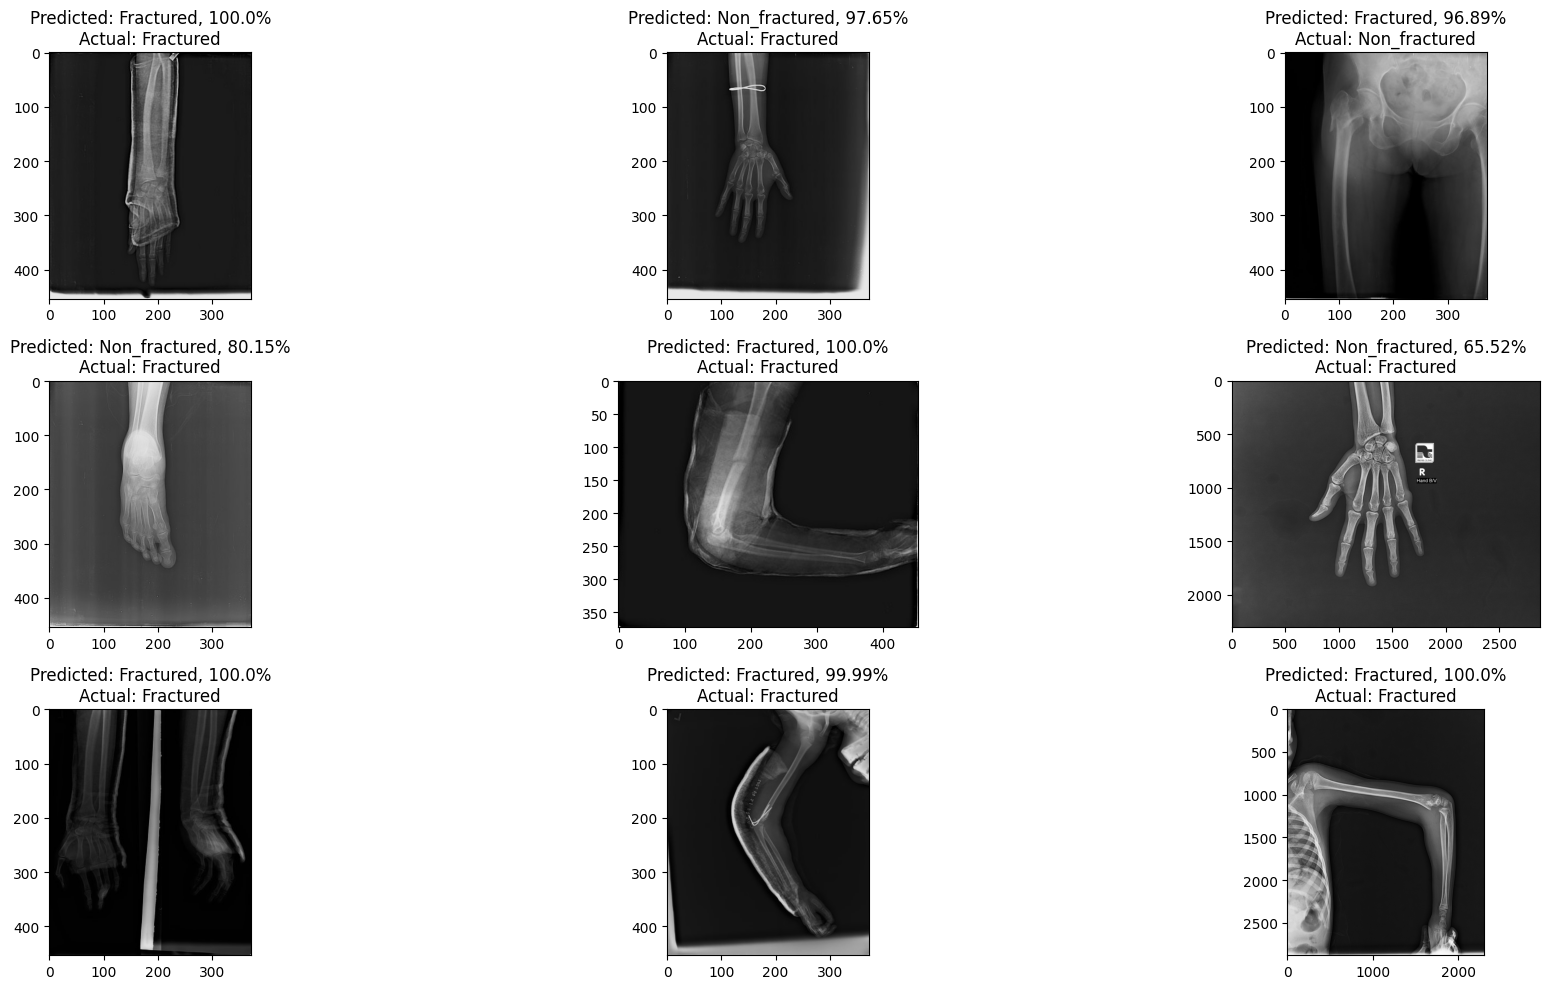

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
index = 0
for i in range(3):
    for j in range(3):
        image = Image.open(test[index, 0]).convert("RGB")
        axes[i][j].imshow(np.array(image))
        axes[i][j].set_title("Predicted: {}, {}%\nActual: {}".format(index_label[pred[index]], round(probs[index]*100, 2),
                                                               index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()